In [107]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np
import itertools

from pureEM_nback import *

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load trained data

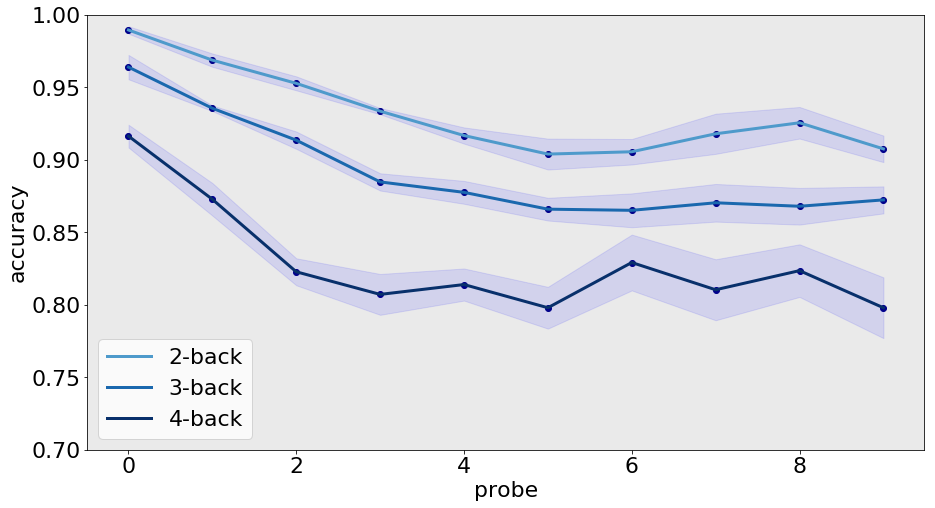

In [103]:
plt.figure(figsize=(15,8))
ax = plt.gca()

nbackL = [2,3,4]
driftL = [5]

cL = [plt.get_cmap('Blues')(i) for i in [150,200,300]]
# acc_arr = -np.ones(4,10)
L = []
for drift,nback in itertools.product(driftL,nbackL):
  fpathL = glob('model_data/eval_acc-nback_%i-context_drift_%i-seed_*.npy'%(nback,drift))
  accL = []
  for fpath in fpathL:
    score = np.load(fpath)
    acc = score.mean(0)
    accL.append(acc)
  acc_arr = np.array(accL)
  
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(len(acc_arr))
  ax.plot(M,label='%i-back'%(nback),lw=3,color=cL[nback-2])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='blue')
  ax.scatter(range(len(M)),M,c='darkblue')
  
ax.set_facecolor(plt.get_cmap('Greys')(40))
ax.set_ylabel('accuracy')
ax.set_xlabel('probe')
ax.set_ylim(.7,1)
plt.legend()
# plt.savefig('figures/eval_acc-234back')

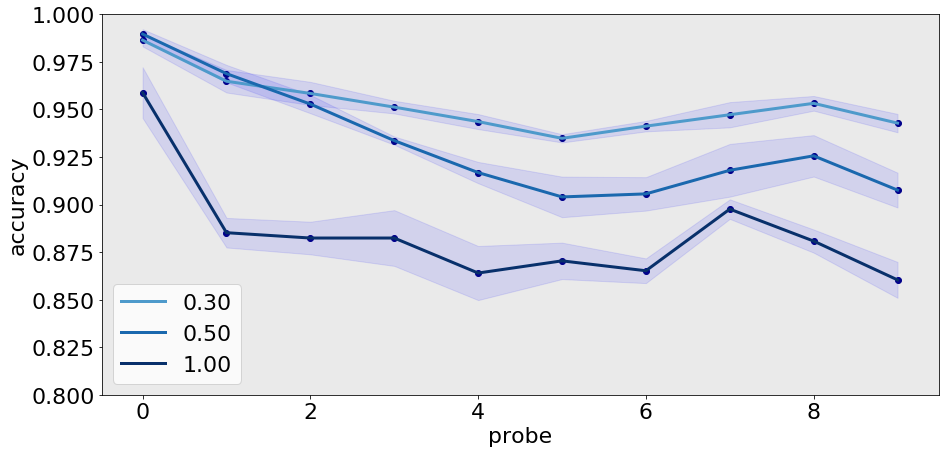

In [129]:
plt.figure(figsize=(15,7))
ax = plt.gca()

nbackL = [2]
driftL = [3,5,10]

cL = [plt.get_cmap('Blues')(i) for i in [150,200,300,400]]
# cL = ['r','g','b']
# acc_arr = -np.ones(4,10)
L = []
for idx,(drift,nback) in enumerate(itertools.product(driftL,nbackL)):
  fpathL = glob('model_data/eval_acc-nback_%i-context_drift_%i-seed_*.npy'%(nback,drift))
  accL = []
  for fpath in fpathL:
    score = np.load(fpath)
    acc = score.mean(0)
    accL.append(acc)
  acc_arr = np.array(accL)
  
  M = acc_arr.mean(0)
  S = acc_arr.std(0)/np.sqrt(len(acc_arr))
  ax.plot(M,label='%.2f'%(drift/10),lw=3,color=cL[idx])
  ax.fill_between(range(len(M)),M-S,M+S,alpha=.1,color='blue')
  ax.scatter(range(len(M)),M,c='darkblue')
  
ax.set_facecolor(plt.get_cmap('Greys')(40))
ax.set_ylabel('accuracy')
ax.set_xlabel('probe')
ax.set_ylim(.8,1)
plt.legend()
plt.savefig('figures/eval_acc-bydrift')

## train

In [108]:
## sweeping params
seed = 2
tr.manual_seed(seed)
np.random.seed(seed)

In [109]:
nback=2
ntrials=10+nback
ntokens_og=3
stsize = 30
context_edim = 5
context_drift_std = .5
stim_edim = 10

# ntrials=5
# ntokens_og=3
# stsize = 3
# context_edim = 2
# stim_edim = 2


task = NBackTask(ntokens_og,ntrials)
net = Net(context_edim+stim_edim,stsize,seed,debug=False)

lossop = tr.nn.CrossEntropyLoss()
optiop = tr.optim.Adam(net.parameters(), lr=0.001)

-- proportion of true trials: M=0.47 S=0.13


In [110]:
nepochs=50000
  
def emb(stim_t_int,context_t_int,stim_emat,context_emat):
  xt_s_emb = stim_emat[stim_t_int].unsqueeze(0)
  xt_c_emb = context_emat[context_t_int].unsqueeze(0)
  xt_emb = tr.cat([xt_s_emb,xt_c_emb],-1) 
  return xt_emb
  
ep_loss = -np.ones([nepochs,ntrials-nback])
A = -np.ones(nepochs)

for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # embeddings matrices
  context_emat = tr.Tensor(task.generate_context_drift(ntrials,context_edim,context_drift_std))
  stim_emat = tr.randn(ntokens_og,stim_edim)
  # epoch data
  T,X,Y = task.gen_episode_data()
#   print('S=',X)
  X = tr.LongTensor(X)
  Y = tr.LongTensor(Y)
  # initial lstm
  h_t,c_t = tr.zeros(2,1,stsize)
  # initialize memory
  memoryL = []
  for tstep in range(nback):
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    memoryL.append(xt_emb)
  net.init_memory(memoryL)
  # unroll
  acc = 0
  for tstep in range(nback,ntrials):
    # embed input
    x_t_int = X[tstep]
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    # fp
    yhat,h_k,c_k = net(xt_emb,h_t,c_t)
    net.encode(xt_emb)
    # bp
    ytarget = Y[tstep].unsqueeze(0)
    loss = lossop(yhat,ytarget)
    ep_loss[ep,tstep-2] = loss.item()
    optiop.zero_grad()
    loss.backward(retain_graph=True)
    optiop.step()
    acc += tr.argmax(tr.softmax(yhat,1),1)==ytarget 
  A[ep] = acc.numpy()/(ntrials-nback)
  


0.0
0.2
0.4
0.6
0.8


In [111]:
def mov_avg(X,wind=20):
  MA = []
  for t in range(X.shape[0]-wind):
    MA.append(np.mean(X[t:t+wind]))
  return np.array(MA)

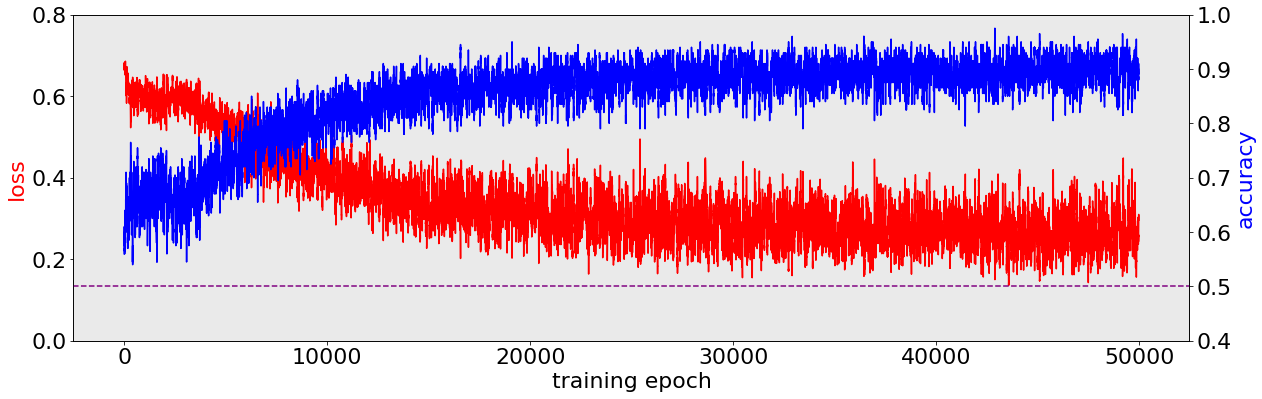

In [112]:

plt.figure(figsize=(20,6))
ax = plt.gca()
ax2 = ax.twinx()

L = ep_loss.mean(1)
ax.plot(mov_avg(L),c='r')
MA = mov_avg(A)
ax2.plot(range(len(MA)),MA,color='blue')

ax.set_ylabel('loss',color='r')
ax.set_xlabel('training epoch',color='k')
ax2.set_ylabel('accuracy',color='blue')
ax2.set_ylim(0.4,1)

ax.set_ylim(0,0.8)
plt.axhline(0.5,c='purple',ls='--')
ax.set_facecolor(plt.get_cmap('Greys')(40))

# plt.savefig('figures/training_loss_acc-nback_%i-drift%i'%(nback,context_drift_std*10))

# eval

In [ ]:
nepochs=500
  
score = -np.ones([nepochs,ntrials-nback])

for ep in range(nepochs):
  if ep%(nepochs/5)==0:
    print(ep/nepochs)
  # embeddings matrices
  context_emat = tr.Tensor(task.generate_context_drift(ntrials,context_edim))
  stim_emat = tr.randn(ntokens_og,stim_edim)
  # epoch data
  T,X,Y = task.gen_episode_data()
#   print('S=',X)
  X = tr.LongTensor(X)
  Y = tr.LongTensor(Y)
  # initial lstm
  h_t,c_t = tr.zeros(2,1,stsize)
  # initialize memory
  memoryL = []
  for tstep in range(nback):
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    memoryL.append(xt_emb)
  net.init_memory(memoryL)
  # unroll
  for tstep in range(nback,ntrials):
    # embed input
    x_t_int = X[tstep]
    xt_emb = emb(X[tstep],tstep,stim_emat,context_emat)
    # fp
    yhat,h_k,c_k = net(xt_emb,h_t,c_t)
    net.encode(xt_emb)
    # bp
    ytarget = Y[tstep].unsqueeze(0)
    score[ep,tstep-nback] = tr.argmax(tr.softmax(yhat,1),1)==ytarget 

# np.save('model_data/eval_acc-nback_%i-context_drift_%i-seed_%i'%(nback,context_drift_std*10,seed),score)

In [ ]:
plt.figure(figsize=(15,6))

ax = plt.gca()
M = score.mean(0)
S = score.std(0)/np.sqrt(len(score))
# plt.bar(range(len(M)),M,yerr=S)

ax.plot(M,c='b')
ax.scatter(range(len(M)),M,c='darkblue')
ax.fill_between(range(len(M)),M-S,M+S,alpha=.15,color='b')
ax.set_xlabel('eval probe',color='k')
ax.set_ylabel('accuracy',color='k')

ax.set_ylim(0.88,1.01)
ax.set_yticks(np.arange(0.9,1.01,0.05))

for t in np.arange(0.9,1.01,0.025):
  ax.axhline(t,c='k',ls='--',lw=.25)


# plt.savefig('figures/eval_acc-nback_%i-drift%i'%(nback,context_drift_std*10))